# Класифікація зображень  жестів на Keras-Tensorflow
### Структура ноутбуку:
 1)Завантаження зображень <br>
 2)Передобробка зображень<br>
 3)Створення конволюційної нейронної мережі (CNN)<br>
 4)Тренування та оцінка моделі<br>
 5) Застосування створеної моделі<br>


In [41]:
import tensorflow as tf
import cv2
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D


## Завантаження даних

In [52]:
import os

data = []

IMG_SIZE = (64,64)
data_dir = "data/"
categories = []
for img in os.listdir(data_dir):
    category = img.split('.')[0]
    if category not in categories:
        categories.append(category)
    img_path = os.path.join(data_dir,img)
    img_arr = cv2.imread(img_path,0)
    img_arr = cv2.resize(img_arr, IMG_SIZE)
    img_arr = np.reshape(img_arr, (IMG_SIZE[0],IMG_SIZE[1],1))
    data.append([img_arr,categories.index(category)])
        
import random
random.shuffle(data)

## Розділення даних на тренувальні та тестові

In [53]:
print(len(data))
split = 0.7
train_data = data[0:int(len(data)*split)]
test_data = data[int(len(data)*split):-1]

80


## Форматування даних 

In [54]:
X_train = []
y_train = []
for img,label in train_data:
    X_train.append(img)
    y_train.append(label)
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []
for img,label in test_data:
    X_test.append(img)
    y_test.append(label)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [55]:
# Callback для припинення тренування, при умові досягнення точності 100%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,log={}):
        if log.get('acc')==1.0:
            self.model.stop_training = True
            return

callback = myCallback()

In [56]:
print(X_train[0].shape)

(64, 64, 1)


## Створення нейронної мережі

In [58]:
#Додати зображення архітектури
model = tf.keras.models.Sequential()
model.add(Conv2D(32,(3,3),input_shape=(64,64,1),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2))) #if stride not given it equal to pool filter size
model.add(Conv2D(32,(3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dense(units=len(categories),activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Тренування Мережі

In [61]:
model.fit(X_train, y_train, epochs=500, callbacks=[callback])

Epoch 1/500
56/56 [==============================] - 1s 12ms/sample - loss: 36.7333 - acc: 0.2321
Epoch 2/500
56/56 [==============================] - 0s 7ms/sample - loss: 79.5583 - acc: 0.2679
Epoch 3/500
56/56 [==============================] - 0s 7ms/sample - loss: 25.2110 - acc: 0.3929
Epoch 4/500
56/56 [==============================] - 0s 7ms/sample - loss: 2.6539 - acc: 0.6071
Epoch 5/500
56/56 [==============================] - 0s 7ms/sample - loss: 0.6843 - acc: 0.8036
Epoch 6/500
56/56 [==============================] - 0s 7ms/sample - loss: 0.2838 - acc: 0.8929
Epoch 7/500
56/56 [==============================] - 0s 7ms/sample - loss: 0.1205 - acc: 0.9464
Epoch 8/500
56/56 [==============================] - 0s 7ms/sample - loss: 0.0474 - acc: 1.0000


## Оцінення моделі на тестових даних та збереження моделі

In [63]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(test_loss, test_acc)

23/23 [==============================] - 0s 2ms/sample - loss: 0.0653 - acc: 1.0000
0.06526074558496475 1.0


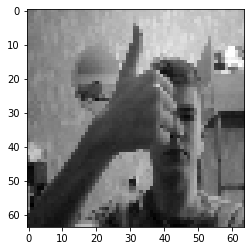

In [64]:
import matplotlib.pyplot as plt
plt.imshow(X_test[1], cmap="gray")

In [65]:
model.save('sign_reader.model')

## Передбачення

In [66]:
new_model = tf.keras.models.load_model('sign_reader.model')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [67]:
predictions = new_model.predict(X_test)

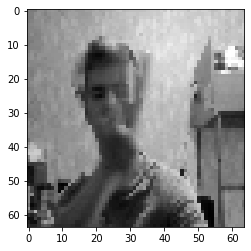

In [68]:
import matplotlib.pyplot as plt
plt.imshow(X_test[3], cmap="gray")

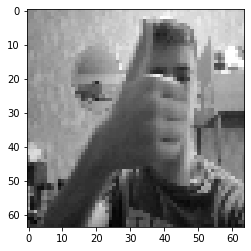

In [69]:
plt.imshow(X_test[7], cmap="gray")

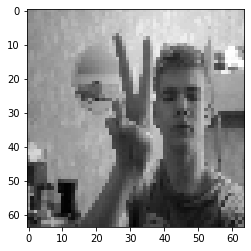

In [70]:
plt.imshow(X_test[6], cmap="gray")

In [71]:
print(predictions[3])
print(predictions[7])
print(predictions[6])


[9.2254362e-05 2.3375072e-04 9.9422920e-01 5.4447446e-03]
[2.6609447e-05 9.9417603e-01 5.1658586e-05 5.7455665e-03]
[2.3684944e-07 1.6576327e-09 9.9999726e-01 2.5249610e-06]


In [74]:
print(categories[np.argmax(predictions[3])])
print(categories[np.argmax(predictions[7])])
print(categories[np.argmax(predictions[6])])

peace
like
peace
